In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
print(mpl.get_backend())
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

module://ipykernel.pylab.backend_inline


In [2]:
def read_file(name, halo_num):
    data = []
    with open('/home/akinshol/Data/Timescales/DataFiles20190731/'+name+'.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def cumulative_sfh(name, halo_num):
    age = 13.800797497330507
    if name=='h148':
        s = pynbody.load('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096')
    else:
        s = pynbody.load('/home/christenc/Data/Sims/'+name+'.cosmo50PLK.3072g/'+name+'.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/'+name+'.cosmo50PLK.3072gst5HbwK1BH.004096')
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar 
    return c_sfh, age-bincenters


In [6]:
def CaseStudyPlots(simulation_name,i,filename=True, ret = False):

    data = read_file(simulation_name, i)
    # data[:10]

    age = 13.800797497330507
    q_thresh = 0.9
    i_thresh = 1.0
    
    print('Gathering data...')
    time = age - np.array(data['time'], dtype=float)
    gasfrac = np.array(data['gasfrac'], dtype=float)
    gastemp = np.array(data['gtemp'], dtype=float)
    ratio = np.array(data['ratio'], dtype=float)
    dist = np.array(data['h1dist'], dtype=float)
    SNHf = np.array(data['SNHfrac'], dtype=float)
    fHI = np.array(data['fHI'], dtype=float)
    mvir = np.array(data['mass'], dtype=float)
    HIratio = np.array(data['HIratio'], dtype=float)
    mHI = np.array(data['HIratio'],dtype=float)*np.array(data['mstar'],dtype=float)
    mgas = np.array(data['mgas'],dtype=float)
    c_sfh, bc = cumulative_sfh(simulation_name, i)

    shaded_min = -1
    shaded_max = 500*np.max(mgas)

    fig, ax = plt.subplots(1,4,figsize=(24,4),dpi=300)
    
    ax[3].plot(time,dist,'g-')
    ax[3].invert_xaxis()
    ax[3].set_xlabel('Lookback Time [Gyr]')
    label3 = ax[3].set_ylabel(r'Distance from Host [$R_{\mathrm{vir}}$]')
    label3.set_color('g')
    ax[3].semilogy()
    ax[3].set_xlim(14,0)
    ax[3].set_ylim(0.1, 25)

    ax1 = ax[3].twinx()
    ax1.plot(time,ratio,'m-')
    label4 = ax1.set_ylabel(r'$P_{\mathrm{ram}} / P_{\mathrm{rest}}$')
    label4.set_color('m')
    try:
        ax1.set_ylim(np.min(ratio[~np.isnan(ratio)])-0.3, np.max(ratio[~np.isnan(ratio)])+1)
    except:
        ax1.set_ylim(0., 10)
    npeaks = 1
    peak_indices = np.argsort(ratio[~np.isnan(ratio)])[-npeaks:]


    ax[3].fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for index in peak_indices:
        t = time[~np.isnan(ratio)][index]
        ax[3].plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)

    
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for i in [0,1,2]:
        for index in peak_indices:
            t = time[~np.isnan(ratio)][index]
            ax[i].plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)


    ax[0].plot(bc, c_sfh, 'r-')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('Lookback Time [Gyr]')
    label1 = ax[0].set_ylabel('Cumulative, Normalized SFH')
    label1.set_color('r')
    ax[0].set_ylim(-0.05,1.05)
    ax[0].set_xlim(14,0)

    ax0 = ax[0].twinx()
    ax0.plot(time,HIratio,'b-')
    ax0.set_ylim(-1,10)
    label2 = ax0.set_ylabel(r'$M_{\mathrm{HI}}\ /\ M_{*}$')
    label2.set_color('b')
    t = np.max(bc[c_sfh >= 0.99])

    for i in [0,1,2]:
        ax[i].plot([t,t],[shaded_min,shaded_max], 'r--', linewidth=1)


    ax[1].plot(time,mHI,color='#370ec2',label='HI', linestyle='-')
    ax[1].plot(time,mgas,color='#370ec2',label='All Gas', linestyle='--')
    ax[1].set_xlabel('Lookback Time [Gyr]')
    label = ax[1].set_ylabel(r'Gas Mass [$M_{\odot}$]')
    label.set_color('#370ec2')
    ax[1].legend(frameon=False)
    ax[1].semilogy()
    ax[1].invert_xaxis()
    ax[1].set_xlim(14,0)
    allgas = np.append(mgas,mHI)
    allgas = allgas[(~np.isnan(allgas)) & (allgas!=0)]
    ax[1].set_ylim(0.5*np.min(allgas),1.4*np.max(allgas))

    ax1 = ax[1].twinx()
    ax1.plot(time,gastemp,'k-')
    ax1.invert_xaxis()
    ax1.set_xlabel('Lookback Time [Gyr]')
    ax1.set_ylabel('Mean Gas Temperature [K]')
    ax1.set_xlim(14,0)
    ax1.set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.05*np.max(gastemp[~np.isnan(gastemp)]))

    # ax[2].set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.4*np.max(gastemp[~np.isnan(gastemp)]))
    # ax[2].plot(time,data['outflow_temp_23'],label='Outflow')
    # ax[2].plot(time,data['inflow_temp_23'],label='Inflow')
    # ax[2].legend(frameon=False, prop={'size':9})
    # ax[2].semilogy()


    netflux = data['outflow_91'] + data['inflow_91']
    # ax[2].plot(time, netflux, color='#ad7617', linestyle='-')
    # ax[2].invert_xaxis()
    # label5 = ax[2].set_ylabel(r'Net Gas Flux [$M_{\mathrm{\odot}}\ \mathrm{yr}^{-1}$]')
    # label5.set_color('#ad7617')
    # ax[2].set_ylim(1.2*np.min(netflux),1.2*np.max(netflux))
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min,shaded_max, where=(netflux < 0.), edgecolor='none',alpha=0.2, facecolor='#ad7617')

    ax[2].invert_xaxis()
    ax[2].plot(time,abs(data['outflow_91']), color='r',label='outflow')
    ax[2].plot(time,abs(data['inflow_91']), color='orange', label='inflow')
    ax[2].set_ylabel('Outflow Rate / Inflow Rate')
    ax[2].legend(frameon=False)
    alloutflows = np.append(abs(data['outflow_91']),abs(data['inflow_91']))
    alloutflows = alloutflows[~np.isnan(alloutflows)]

    if (alloutflows == 0.).all():
        ax[2].set_ylim(-0.001,0.001)
    else:
        ax[2].set_ylim(-0.001,1.3*np.max(alloutflows))
    ax[2].set_xlim(14,0)

    ax2 = ax[2].twinx()
    
    gas_rho = np.array(data.gas_rho)
    gas_temp = np.array(data.gas_temp)
    gas_mass =np.array(data.gas_mass)
    
    frac_SF = np.array([],dtype=float)
    for i in range(len(data)):
        gm = np.array(gas_mass[i])
        gr = np.array(gas_rho[i])
        #gt = np.array(gas_temp[i])
        if len(gm[gr> 2.4e6])>0:
            m = np.sum(gm[gr > 2.4e6]) / np.sum(gm)
        else:
            m = 0
        frac_SF = np.append(frac_SF, m)
    
    ax2.plot(time, frac_SF , c='b')
    ax2.set_ylim(-0.05,1.05)
    label = ax2.set_ylabel('Dense Gas Fraction')
    label.set_color('b')


    plt.subplots_adjust(wspace=0.45)
#     if filename:
#         f = 'case_study_'+str(simulation_name)+'_'+str(i)+'.png'
#         plt.savefig('CaseStudyPlots/'+f, dpi=300)
#     else:
#         plt.savefig('CaseStudyPlots/'+str(filename), dpi=300)
    plt.show()
    
    if ret:
        return t, time, gasfrac
    

In [7]:
sims = ['h148', 'h148', 'h148', 'h229', 'h229']
ids = [36, 61, 80, 27, 73]

Gathering data...


<Figure size 432x288 with 0 Axes>

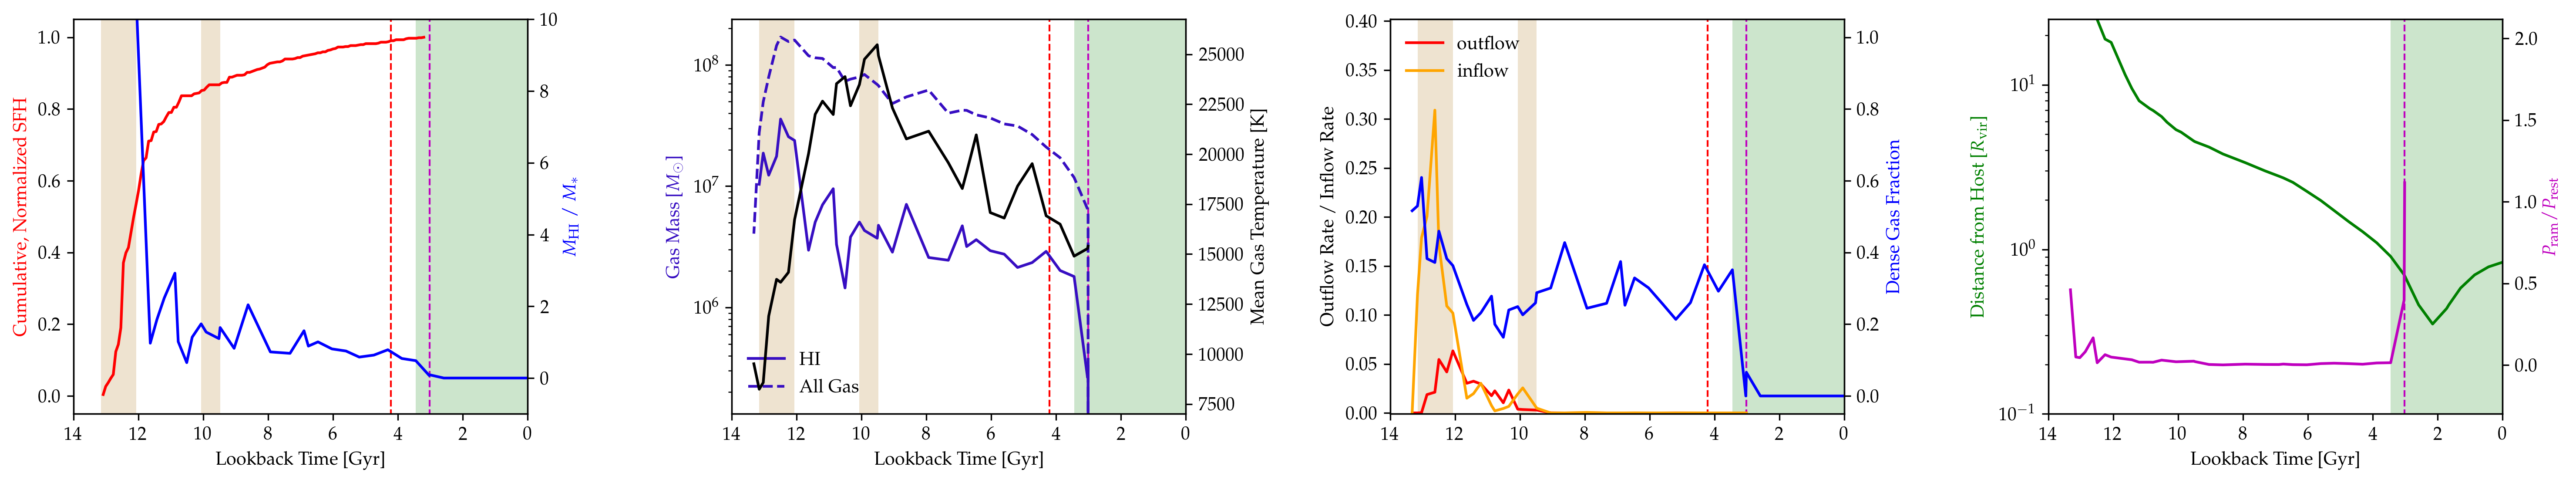

Gathering data...


<Figure size 432x288 with 0 Axes>

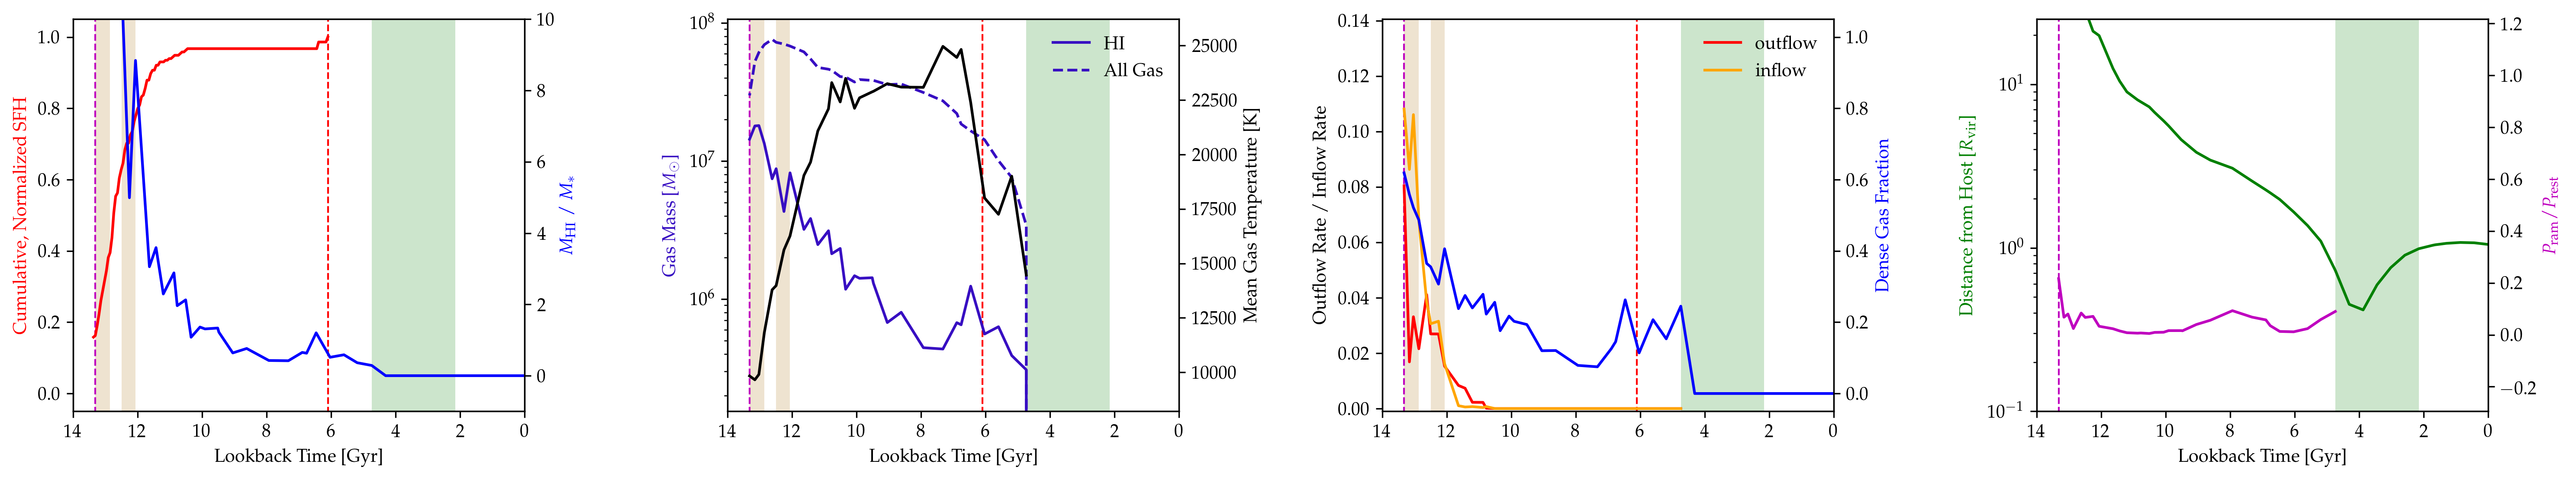

Gathering data...


<Figure size 432x288 with 0 Axes>

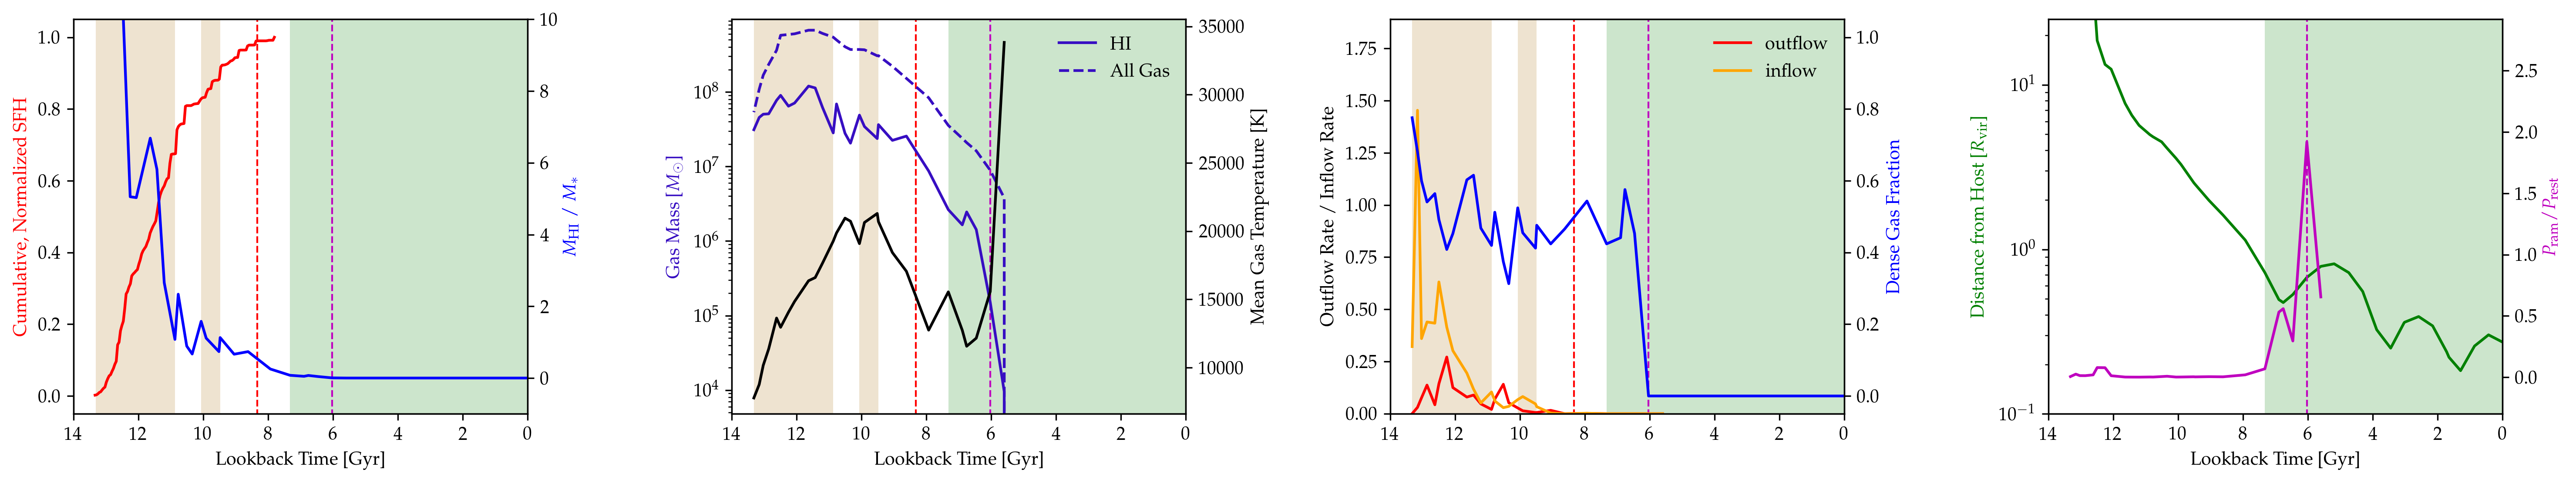

Gathering data...


<Figure size 432x288 with 0 Axes>

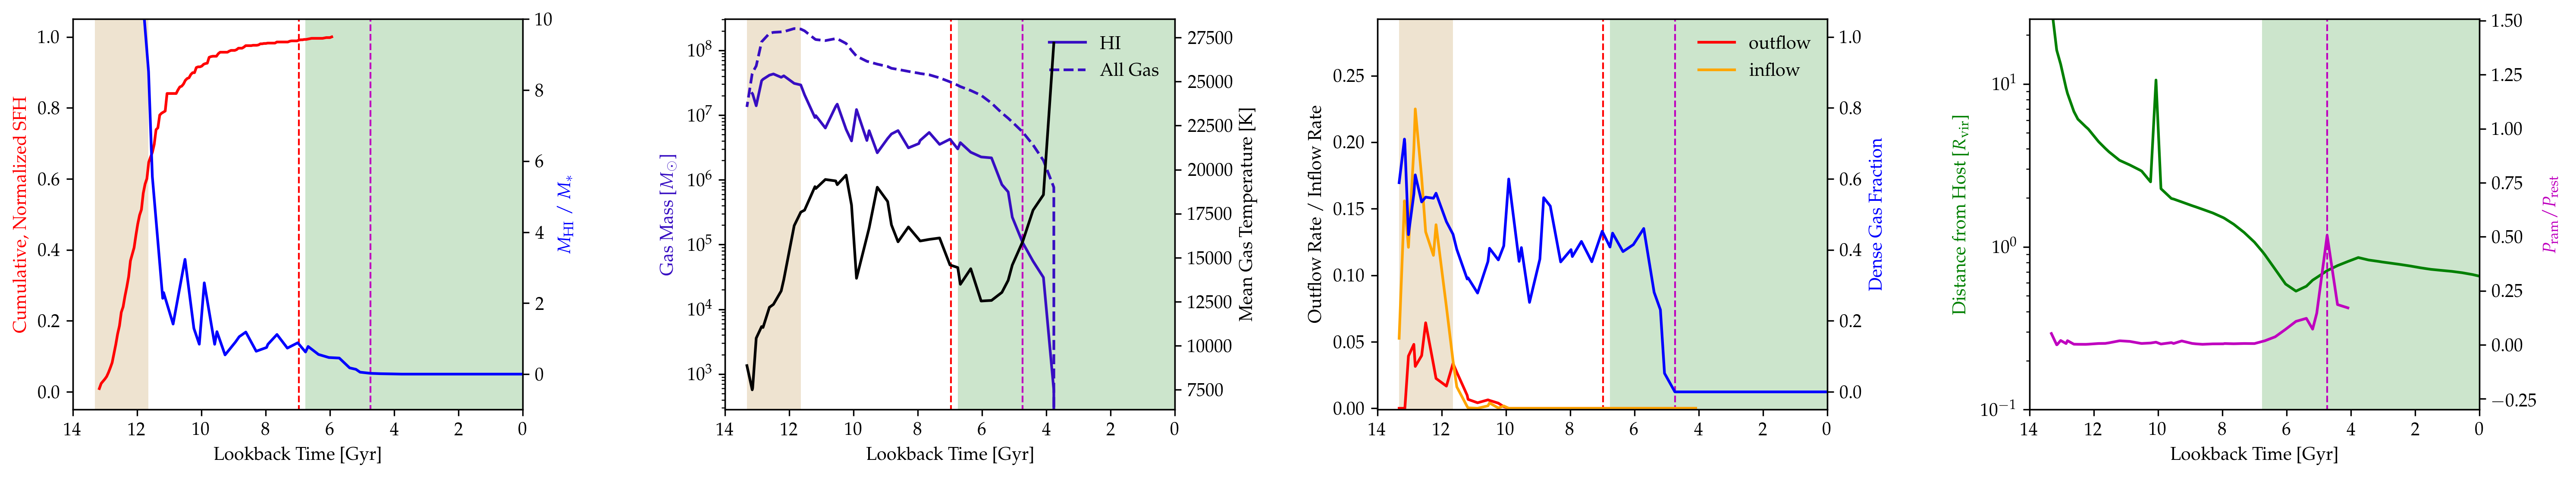

Gathering data...


<Figure size 432x288 with 0 Axes>

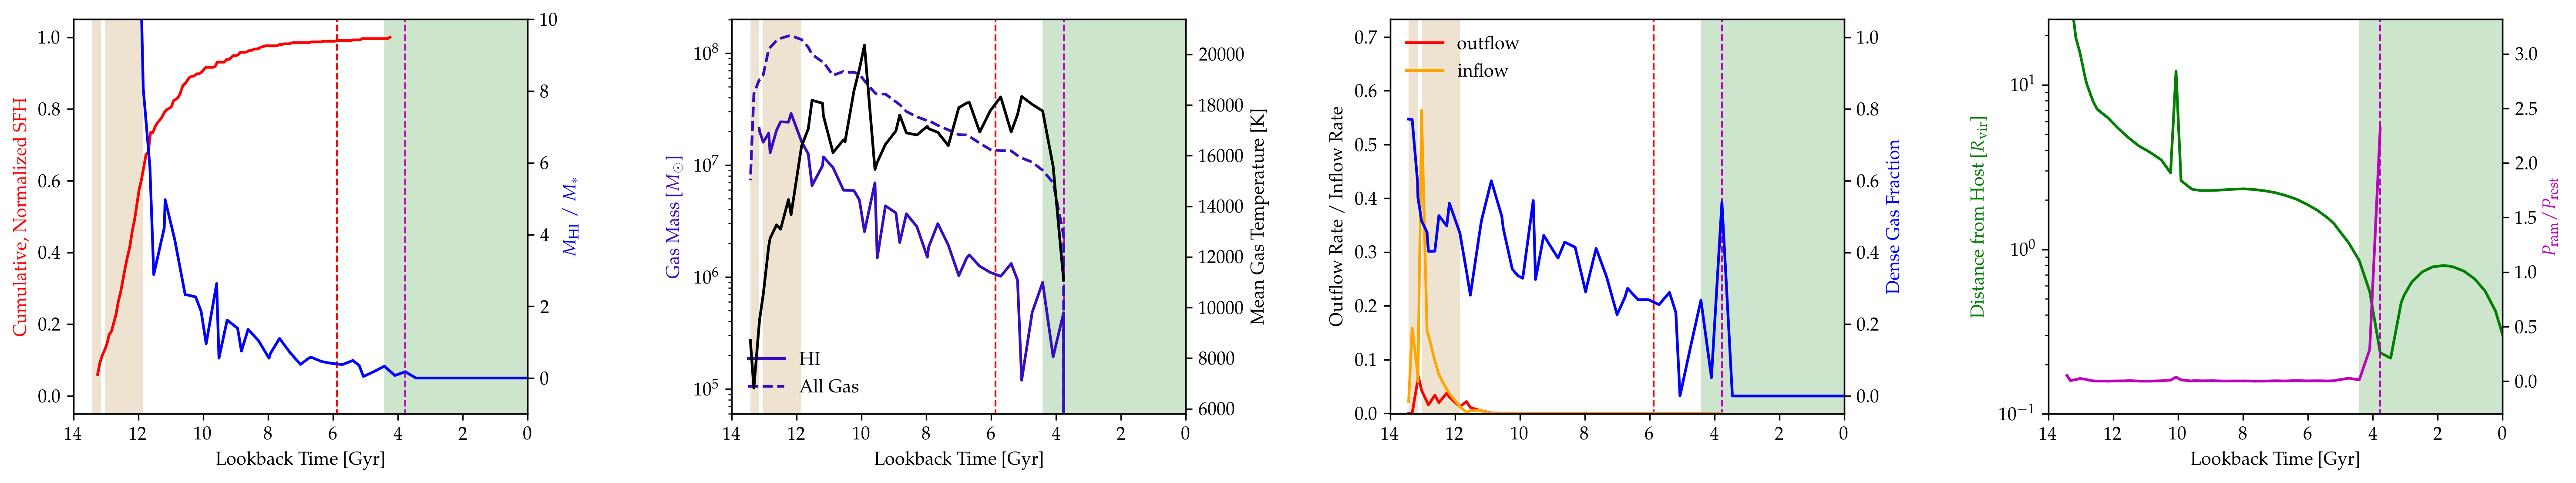

In [8]:
for sim, i in zip(sims,ids):
    CaseStudyPlots(sim,i)

In [9]:
sim, i = sims[-1], ids[-1]

data = read_file(sim,i)
c_sfh, bc = cumulative_sfh(sim, i)

<Figure size 432x288 with 0 Axes>

In [11]:
tquench = np.max(bc[c_sfh > 0.99])
print(tquench)

5.8784639022052065


In [23]:
age = 13.800797497330507
t_until_quench = age - data.time[(data.time > 2)&(age - data.time > tquench)] - tquench
Mout = data.outflow_91[(data.time > 2)&(age - data.time > tquench)]
sfr = data.sfr[(data.time > 2)&(age - data.time > tquench)]
mHI = data.mHI[(data.time > 2)&(age - data.time > tquench)]
mgas = data.mgas[(data.time > 2)&(age - data.time > tquench)]

print(mHI / (Mout+sfr) / 1e9 - t_until_quench)

507                     inf
529                     inf
551                     inf
573                     inf
595                     inf
617                     inf
639       38.56818953915587
661                     inf
683      20.935197800769757
705       37.30757587660234
727      45.585804475330825
749        4.47518206987603
771      48.749297470879846
793      12.097226298576617
815     -0.8583108049627302
837      43.929678272141324
859      0.6357006576502862
881       28.42736177783835
903       5.897658743884254
925      24.621557553439054
947      2.0879888584218413
969       1.681388168142374
991     -3.0326622444736984
1013     -3.501623476697703
1035     -5.077613792107602
1057     -5.211240420608689
dtype: object


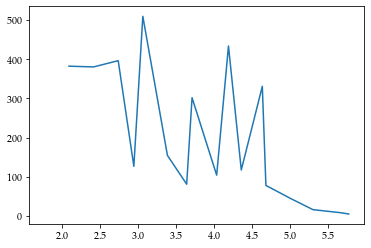

In [25]:
plt.plot(t_until_quench, mgas/(Mout+sfr)/1e9)

plt.show()

In [ ]:
t_until_quench

In [26]:
def read_file(name, halo_num):
    data = []
    with open('/home/akinshol/Data/Timescales/DataFiles/'+name+'.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

data = read_file('h148',3)

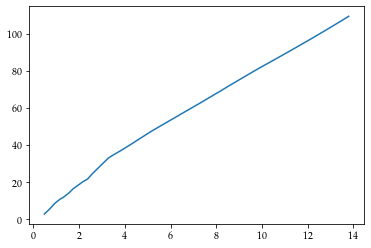

In [28]:

plt.plot(data.time,data.Rvir)
plt.show()